# Title : Forest Cover type Prediction
- 북 콜로라도에 위치한 국립 루즈벨트 공원에 존재하는 4개의 황야지대의 숲데이터셋이 주어진다. 
- 각 데이터셋의 데이터 포인트들은 30제곱미터를 기준으로 한다. 
- 데이터셋을 토대로 숲의 특성으로부터 숲의 나무 종류를 분류하는 것이 목적이다. 

In [21]:
import sklearn
import pandas as pd
import numpy as np
import mglearn
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.display import display

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

In [22]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [23]:
train_id = train.Id
test_id = test.Id
# Id 삭제 
train.drop('Id', axis = 1, inplace=True)
test.drop('Id', axis = 1, inplace=True)

print('train_data shape', train.shape)
print('test_data shape', test.shape)

train_data shape (15120, 55)
test_data shape (565892, 54)


## 변수 설명
- Elevation - Elevation in meters (높이 /meter 단위)
- Aspect - Aspect in degrees azimuth (방위각)
- Slope - Slope in degrees (기울기 각도 /도 단위)
- Horizontal_Distance_To_Hydrology - Horz Dist to nearest surface water features (수원과의 수평거리)
- Vertical_Distance_To_Hydrology - Vert Dist to nearest surface water features (수원과의 수직거리)
- Horizontal_Distance_To_Roadways - Horz Dist to nearest roadway (길가와의 수평거리)
- Hillshade_9am (0 to 255 index) - Hillshade index at 9am, summer solstice (오전 9시의 차양 / 0~255)
- Hillshade_Noon (0 to 255 index) - Hillshade index at noon, summer solstice (정오시의 차양/ 0~255)
- Hillshade_3pm (0 to 255 index) - Hillshade index at 3pm, summer solstice (오후 9시의 차양/ 0~255)
- Horizontal_Distance_To_Fire_Points - Horz Dist to nearest wildfire ignition points (야생 산불 발화지점과의 수평거리)
- Wilderness_Area (4 binary columns, 0 = absence or 1 = presence) - Wilderness area designation (황야 지대 /4종류 ) in Roosevelt National Forest of northern Colorado
- Soil_Type (40 binary columns, 0 = absence or 1 = presence) - Soil Type designation (토양 종류 / 40종류)

- 토양종류와 황야 지대 카테고리별 설명은 https://www.kaggle.com/c/forest-cover-type-prediction/data 참조


## 종속 변수
- Cover_Type (7 types, integers 1 to 7) - Forest Cover Type designation- (산림 유형 / 7종류) (the predominant kind of tree cover)
- 1 - Spruce/Fir
- 2 - Lodgepole Pine
- 3 - Ponderosa Pine
- 4 - Cottonwood/Willow
- 5 - Aspen
- 6 - Douglas-fir
- 7 - Krummholz

In [26]:
# 독립변수와 종속변수 나누기
train_data = train.iloc[:, :-1]
train_target = train.iloc[:, -1]
# train 데이터 갯수 저장
ntrain = len(train)

# train, test데이터 합쳐서 같이 feature engineering
all_data = pd.concat([train_data, test])
print('all_data shape', all_data.shape)

all_data shape (581012, 54)


# 시각화 by ViolinPlot


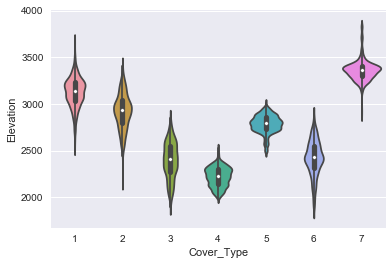

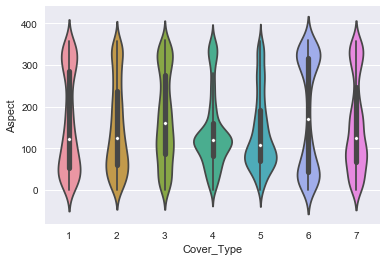

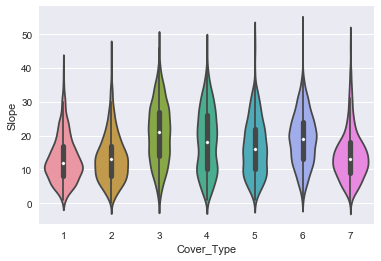

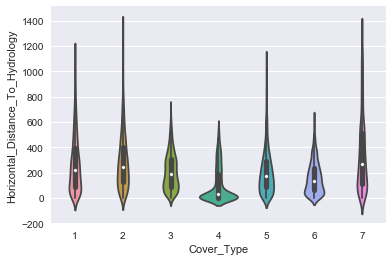

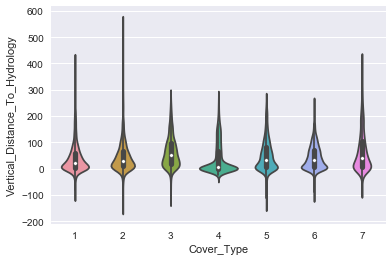

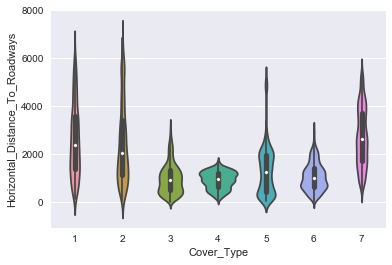

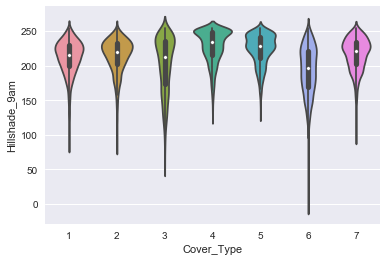

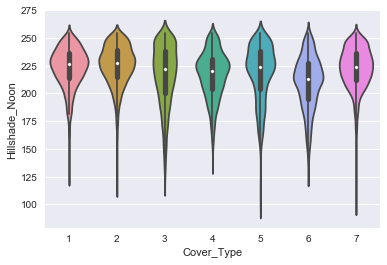

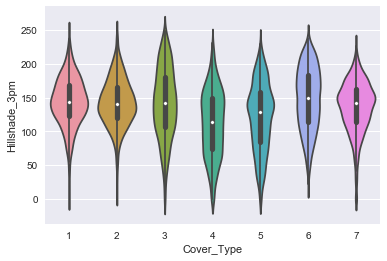

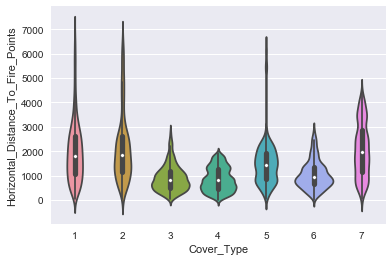

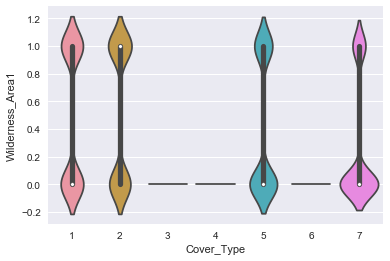

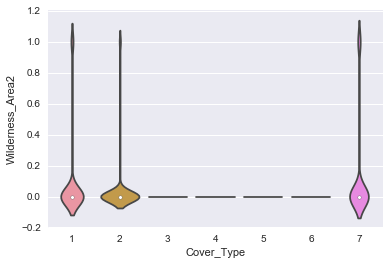

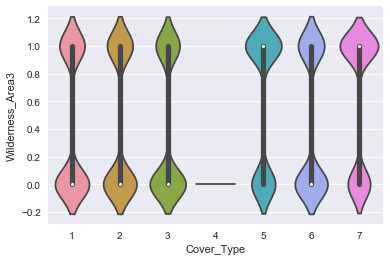

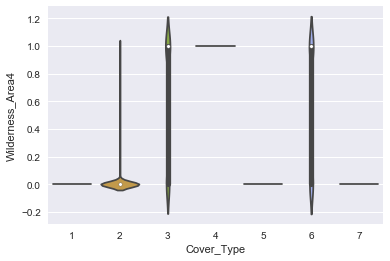

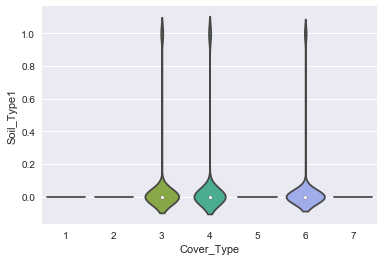

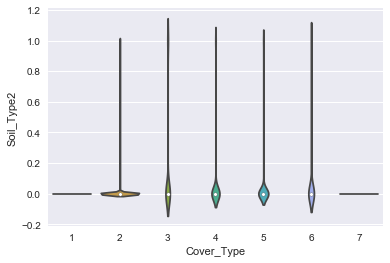

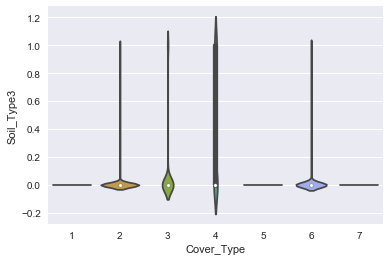

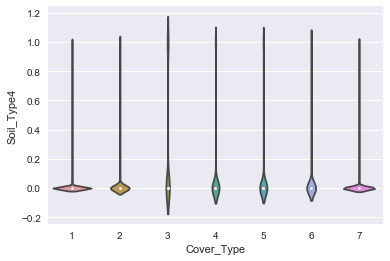

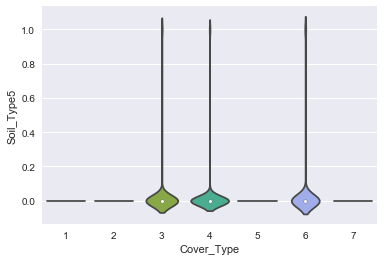

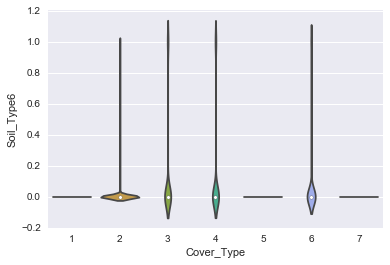

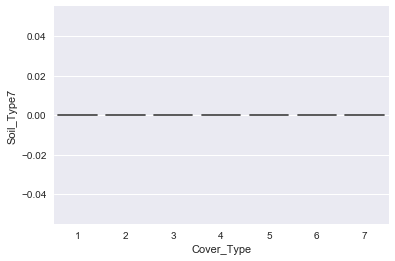

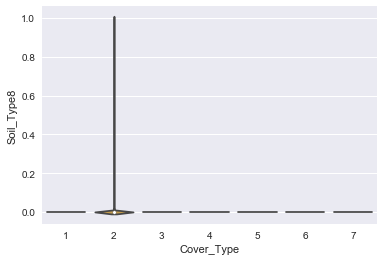

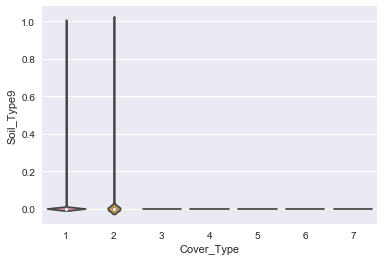

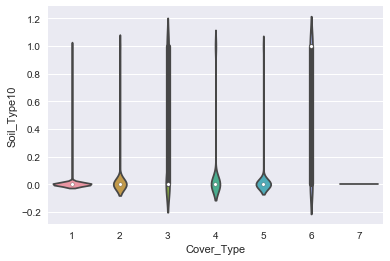

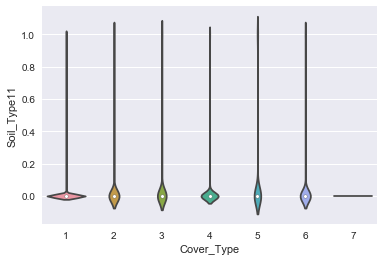

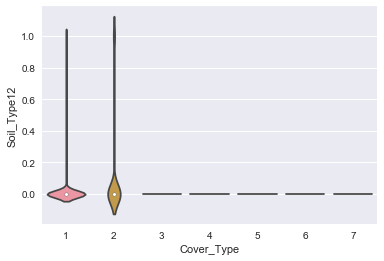

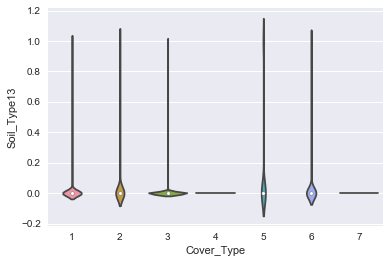

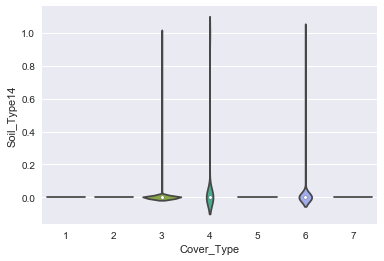

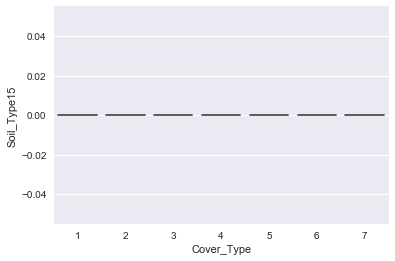

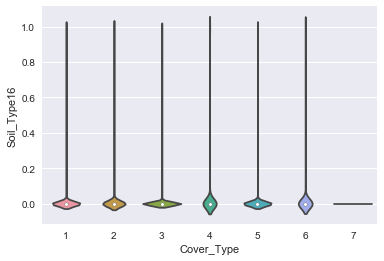

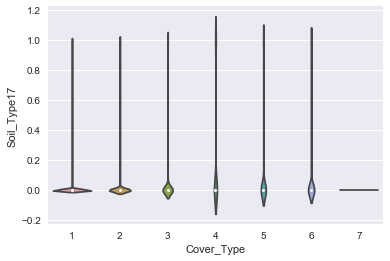

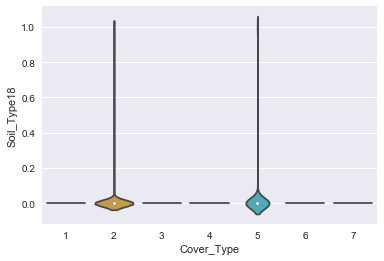

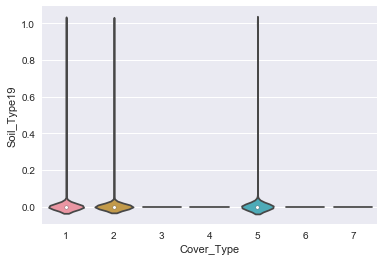

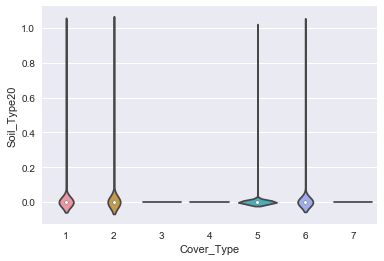

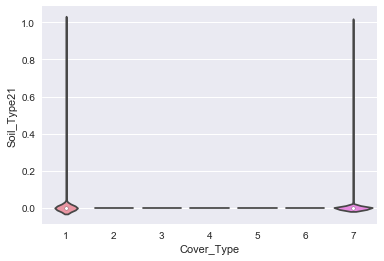

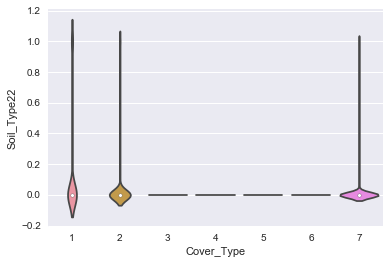

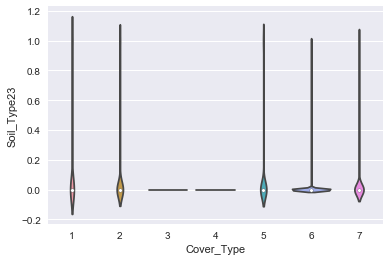

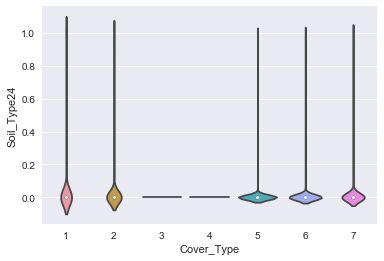

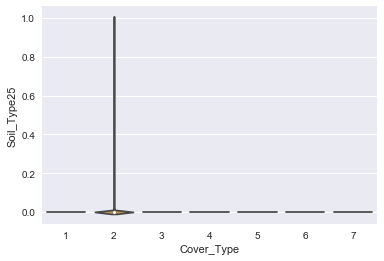

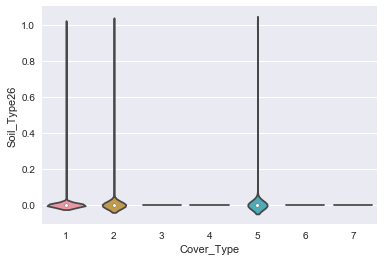

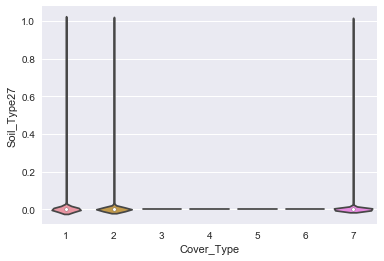

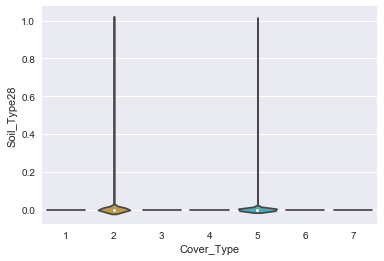

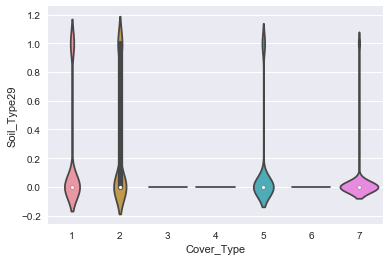

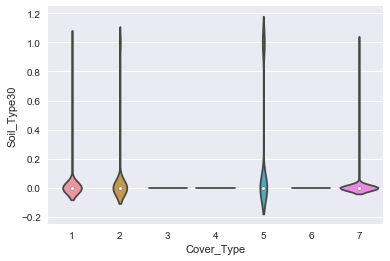

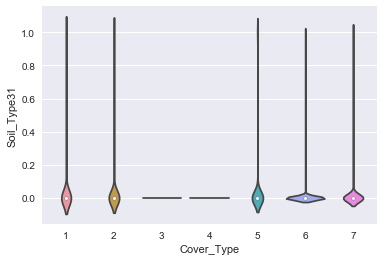

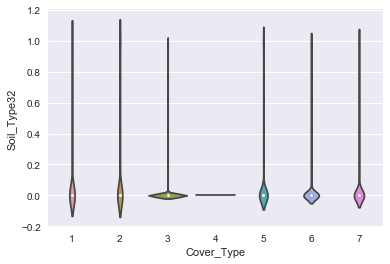

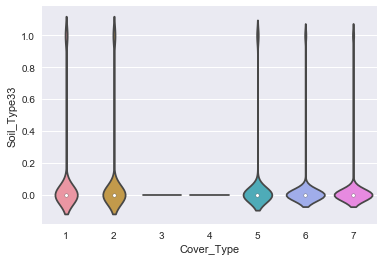

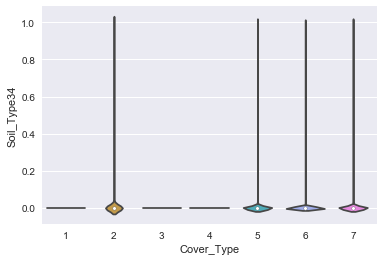

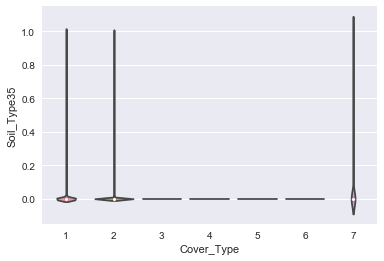

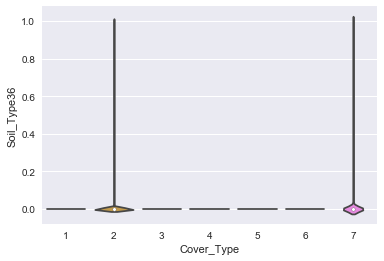

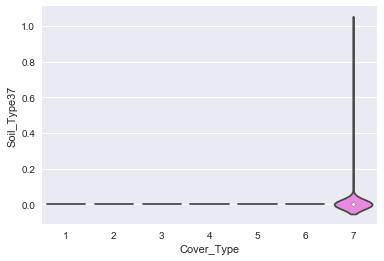

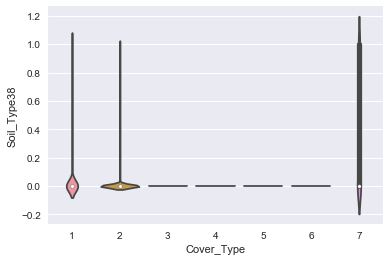

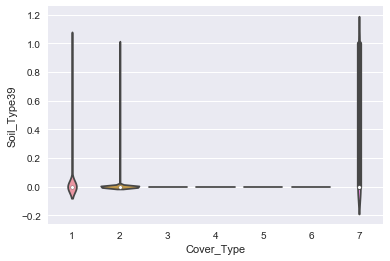

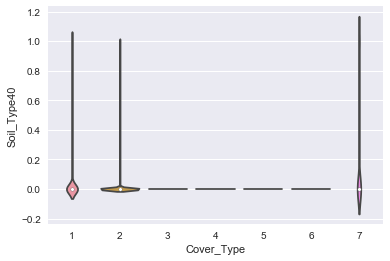

In [27]:
for i in range(train.shape[1] - 1):
    sns.violinplot(train.iloc[:, -1] ,y=train.iloc[:, i])
    plt.show()

# type 변수들 관찰
- Soil_type7, 8, 15, 25는 훈련데이터에서 한 카테고리가 1 이하로 나왔으므로 의미가 없다. 

In [28]:
train.loc[:, 'Wilderness_Area1':'Cover_Type'].sum(axis = 0)

Wilderness_Area1     3597
Wilderness_Area2      499
Wilderness_Area3     6349
Wilderness_Area4     4675
Soil_Type1            355
Soil_Type2            623
Soil_Type3            962
Soil_Type4            843
Soil_Type5            165
Soil_Type6            650
Soil_Type7              0
Soil_Type8              1
Soil_Type9             10
Soil_Type10          2142
Soil_Type11           406
Soil_Type12           227
Soil_Type13           476
Soil_Type14           169
Soil_Type15             0
Soil_Type16           114
Soil_Type17           612
Soil_Type18            60
Soil_Type19            46
Soil_Type20           139
Soil_Type21            16
Soil_Type22           345
Soil_Type23           757
Soil_Type24           257
Soil_Type25             1
Soil_Type26            54
Soil_Type27            15
Soil_Type28             9
Soil_Type29          1291
Soil_Type30           725
Soil_Type31           332
Soil_Type32           690
Soil_Type33           616
Soil_Type34            22
Soil_Type35 

In [29]:
drop_columns = ['Soil_Type7', 'Soil_Type8', 'Soil_Type15', 'Soil_Type25']

In [30]:
train.iloc[:,:10].shape

(15120, 10)

In [31]:
all_data.drop(drop_columns, axis = 1, inplace = True)

In [32]:
train_data = all_data[:ntrain]
test = all_data[ntrain:]
print(train_data.shape)
print(test.shape)


(15120, 50)
(565892, 50)


# Feature Selection By Model
- XGB
- RandomForest
- ExtraTreeClassifier
- GradientBoost

In [12]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import *

C:\Users\POWER USER\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [13]:
def cv_score(model, train_data, train_target):
    cv = KFold(n_splits=5, shuffle = True, random_state = 42).get_n_splits(train_data.values)
    return cross_val_score(model, train_data, train_target, scoring='accuracy', cv= cv)

- 각 스케일러 별로 모델들을 학습시켜 importance들의 리스트를 구한다.
- 평균을 내어서 순위를 매겨 가장 높은 중요도를 가진 feature들로 정렬한다. 

In [14]:
#XGB
#xgb =  XGBClassifier(n_estimators=400, max_depth=7, min_child_weight=4, objective='multi:softmax', nthread = -1)
# RandomForest
rf = RandomForestClassifier(n_estimators=300, max_depth=15, min_samples_leaf=2, random_state=42, n_jobs=-1)
# extra
extra = ExtraTreesClassifier(n_estimators=300, max_depth=15, min_samples_leaf=2, random_state=42, n_jobs=-1)
# GradientBoost
#gboost = GradientBoostingClassifier(n_estimators=400, max_depth=7)

#score = cv_score(xgb)
#print(score)
#print('xgb : {:.4f}({:.4f})'.format(score.mean(), score.std()))

#score = cv_score(rf, train_data, train_target)
#print('\n',score)
#print('rf : {:.4f}({:.4f})'.format(score.mean(), score.std()))

#score = cv_score(extra)
#print('\n',score)
#print('Extra : {:.4f}({:.4f})'.format(score.mean(), score.std()))

#score = cv_score(gboost)
#print('\n',score)
#print('GBoost : {:.4f}({:.4f})'.format(score.mean(), score.std()))

In [15]:

rf.fit(train_data, train_target)
extra.fit(train_data, train_target)

model_names = ['RandomForest', 'ExtraTree']
importances = [rf.feature_importances_, extra.feature_importances_]

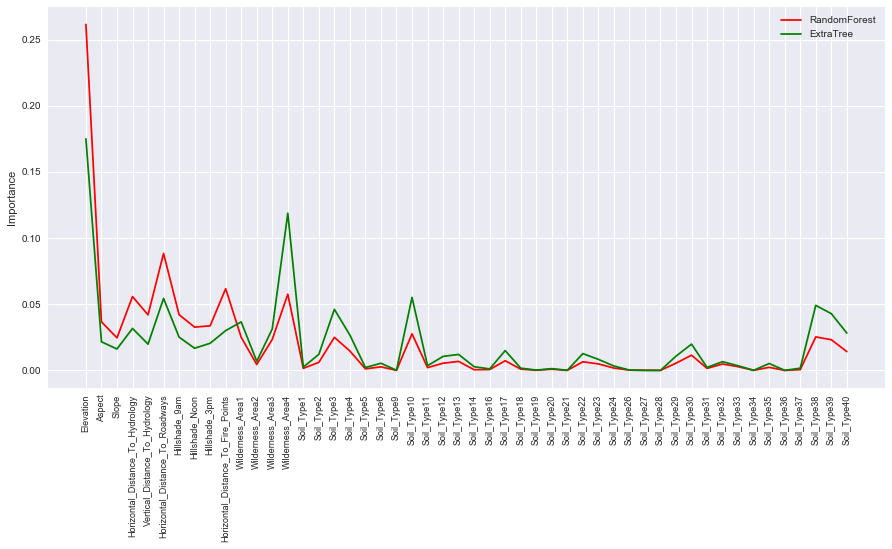

In [16]:
plt.figure(figsize = (15, 7))

for color, importance in zip(['r','g'], importances):
    plt.plot(range(50), importance, c= color)
    ax = plt.gca()
    ax.set_xticks(range(50))
    ax.set_xticklabels(train_data.columns, fontdict={'fontsize': 9, 'rotation': 'vertical'})
    plt.ylabel('Importance')
plt.legend(model_names, loc='best')

In [17]:
feature_importances = pd.Series(np.array(importances).sum(axis = 0), index = train_data.columns).sort_values(ascending=False)
print(feature_importances.head())
importance_rank = feature_importances.index

Elevation                             0.436475
Wilderness_Area4                      0.176408
Horizontal_Distance_To_Roadways       0.142827
Horizontal_Distance_To_Fire_Points    0.091874
Horizontal_Distance_To_Hydrology      0.087560
dtype: float64


# Model Selection
- feature selection의 성과를 측정해보기 위해 가장 높은 순위부터 1, 0.75, 0.5, 0.25 만큼 feature selection한 것을 각각 평가한다.

In [18]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import make_pipeline
import tensorflow as tf

In [19]:
feature_select= [1.0, 0.75, 0.5, 0.25]
feature_select_names = ['all', '3/4', 'half', '1/4']

In [20]:
train_data.shape

(15120, 50)

In [21]:
for name, ratio in zip(feature_select_names, feature_select):
    selected_data = standard_data[importance_rank[: len(importance_rank) * ratio]]
    svc = make_pipeline(StandardScaler(), SVC(C=1000, gamma = 0.1))

    xgb =  XGBClassifier(n_estimators=400, max_depth=7, min_child_weight=4, objective='multi:softmax', nthread = -1)

    rf = RandomForestClassifier(n_estimators=300, max_depth=15, min_samples_leaf=2, random_state=42, n_jobs=-1)

    extra = ExtraTreesClassifier(n_estimators=300, max_depth=15, min_samples_leaf=2, random_state=42, n_jobs=-1)

    gboost = GradientBoostingClassifier(n_estimators=400, max_depth=7)
    print('Test :', name)
    print()
    score = cv_score(svc, selected_data , train_target)
    print(score)
    print('SVC : {:.4f}({:.4f})'.format(score.mean(), score.std()))

    score = cv_score(xgb, selected_data , train_target)
    print(score)
    print('xgb : {:.4f}({:.4f})'.format(score.mean(), score.std()))

    score = cv_score(rf, selected_data , train_target)
    print('\n',score)
    print('rf : {:.4f}({:.4f})'.format(score.mean(), score.std()))

    score = cv_score(extra, selected_data , train_target)
    print('\n',score)
    print('Extra : {:.4f}({:.4f})'.format(score.mean(), score.std()))

    score = cv_score(gboost, selected_data , train_target)
    print('\n',score)
    print('GBoost : {:.4f}({:.4f})'.format(score.mean(), score.std()))
    print('---------------------------------------------------------------------------------------------------------')

C:\Users\POWER USER\Anaconda3\lib\site-packages\pandas\indexes\base.py:1428: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return promote(getitem(key))


Test : all

[ 0.71494709  0.72685185  0.70634921  0.72519841  0.8098545 ]
SVC : 0.7366(0.0374)
[ 0.76686508  0.74470899  0.76521164  0.78306878  0.84589947]
xgb : 0.7812(0.0346)

 [ 0.71494709  0.71759259  0.74537037  0.78406085  0.82638889]
rf : 0.7577(0.0424)

 [ 0.66203704  0.6792328   0.70634921  0.73578042  0.7880291 ]
Extra : 0.7143(0.0445)

 [ 0.77347884  0.75462963  0.77347884  0.7989418   0.85714286]
GBoost : 0.7915(0.0357)
---------------------------------------------------------------------------------------------------------
Test : 3 quantile



C:\Users\POWER USER\Anaconda3\lib\site-packages\pandas\indexes\base.py:1428: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return promote(getitem(key))


[ 0.71593915  0.72685185  0.70403439  0.72420635  0.80720899]
SVC : 0.7356(0.0367)
[ 0.76719577  0.73941799  0.7582672   0.7797619   0.84391534]
xgb : 0.7777(0.0356)

 [ 0.72850529  0.72354497  0.75132275  0.79199735  0.82671958]
rf : 0.7644(0.0394)

 [ 0.66832011  0.68121693  0.7146164   0.75529101  0.80092593]
Extra : 0.7241(0.0488)

 [ 0.77546296  0.74768519  0.77083333  0.78571429  0.85350529]
GBoost : 0.7866(0.0357)
---------------------------------------------------------------------------------------------------------
Test : half



C:\Users\POWER USER\Anaconda3\lib\site-packages\pandas\indexes\base.py:1428: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return promote(getitem(key))


[ 0.70304233  0.71660053  0.70072751  0.72420635  0.8015873 ]
SVC : 0.7292(0.0372)
[ 0.76686508  0.7390873   0.75429894  0.77314815  0.84325397]
xgb : 0.7753(0.0359)

 [ 0.72387566  0.72949735  0.75231481  0.78769841  0.83201058]
rf : 0.7651(0.0403)

 [ 0.68287037  0.69874339  0.71957672  0.74966931  0.79828042]
Extra : 0.7298(0.0409)

 [ 0.75793651  0.75132275  0.76256614  0.78174603  0.85119048]
GBoost : 0.7810(0.0366)
---------------------------------------------------------------------------------------------------------
Test : 1 quantile



C:\Users\POWER USER\Anaconda3\lib\site-packages\pandas\indexes\base.py:1428: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return promote(getitem(key))


[ 0.7228836   0.72089947  0.71693122  0.7364418   0.81415344]
SVC : 0.7423(0.0365)
[ 0.74570106  0.73181217  0.72486772  0.74239418  0.82671958]
xgb : 0.7543(0.0370)

 [ 0.72255291  0.73015873  0.73842593  0.76587302  0.81812169]
rf : 0.7550(0.0348)

 [ 0.69742063  0.70006614  0.70601852  0.74338624  0.79034392]
Extra : 0.7274(0.0356)

 [ 0.74305556  0.74603175  0.73611111  0.73710317  0.82043651]
GBoost : 0.7565(0.0322)
---------------------------------------------------------------------------------------------------------


## Feature Selection/ Model selection 결과
- feature selection 결과 특정모델(Randomforest, SVC)은 아주 미세하게 퍼포먼스가 좋아질 때도 있었지만 전체적으로 CV score는 낮아지는 것을 볼 수 있다.
- Gboost > XGBoost > RandomForest > ExtraTree > SVC 순으로 성과가 좋았다. 
- 본 프로젝트에서는 GBoost의 학습시간이 너무 길기 때문에 XGBclassifier를 메인 모델로 삼기로 결정하였다. 


## 중간 결과 보고
- 더이상의 Feature Engineering을 거치지 않고 실행하였을 때, 어느 이상 결과가 올라가지 않는 것을 관찰할 수 있었다. 
- kaggle 제출 기록을 보아 1번 클래스와 2번 클래스가 현저하게 많은 것을 관찰할 수 있었다. 
- 추가적인 확인 결과 1번 클래스의 스프루스 수종과, 2번 클래스의 파인 수종은 콜로라도 주에서 가장 많은 수를 가지고 있는 수종이었다. 
- 또한 스프루스와 파인은 그 나무 특성이 비슷하여 실제로도 구분이 어렵다고 한다.


## 추가적인 Feature Engineering
- 따라서 여기서 가장 핵심적인 사항은 1번 클래스와 2번클래스를 얼마나 잘 구분하는가로 볼 수 있다.
- 테스트셋 및 실제 데이터는 1,2번이 많은 것에 비해 train 데이터셋은 각 클래스들이 정확하게 균등하게 배분되어있었다. 
- 따라서 오버샘플링을 통해서 train 데이터셋의 1, 2번 클래스의 샘플 수를 늘려주어, 1, 2번을 좀더 잘 구분되도록 하였다. 
- 또한 각 distance에 관련된 feature들에 관해서 추가적은 feature engineering을 진행하였다.
- 수원과의 수직, 수평거리에 더해, 피타고라스 정리를 통해서 절대적인 거리를 추가하였다. 
- 수원과 화재발생지의 거리의 덧셈과 뺄셈을 통해 상대적인 거리를 특성으로 추가하였다.(Hydro_fire)
- 수원과 길가와의 거리의 덧셈과 뺄셈을 통해 상대적인 거리를 특성으로 추가하였다.(Hydro_Road)
- 화재발생지와 길가와의 거리의 덧셈과 뺄셈을 통해 상대적인 거리를 특성으로 추가하였다.(Fire_Roads)
- 아래 plot을 살펴본 결과 새로운 특성이 분류에 도움이 될것이라고 판단할 수 있었다. 

In [33]:
train_data['Distanse_to_Hydrolody'] = (train_data['Horizontal_Distance_To_Hydrology']**2+train_data['Vertical_Distance_To_Hydrology']**2)**0.5
test['Distanse_to_Hydrolody'] = (test['Horizontal_Distance_To_Hydrology']**2+test['Vertical_Distance_To_Hydrology']**2)**0.5

train_data['Hydro_Fire_1'] = train_data['Horizontal_Distance_To_Hydrology']+train_data['Horizontal_Distance_To_Fire_Points']
test['Hydro_Fire_1'] = test['Horizontal_Distance_To_Hydrology']+test['Horizontal_Distance_To_Fire_Points']

train_data['Hydro_Fire_2'] = abs(train_data['Horizontal_Distance_To_Hydrology']-train_data['Horizontal_Distance_To_Fire_Points'])
test['Hydro_Fire_2'] = abs(test['Horizontal_Distance_To_Hydrology']-test['Horizontal_Distance_To_Fire_Points'])

train_data['Hydro_Road_1'] = abs(train_data['Horizontal_Distance_To_Hydrology']+train_data['Horizontal_Distance_To_Roadways'])
test['Hydro_Road_1'] = abs(test['Horizontal_Distance_To_Hydrology']+test['Horizontal_Distance_To_Roadways'])

train_data['Hydro_Road_2'] = abs(train_data['Horizontal_Distance_To_Hydrology']-train_data['Horizontal_Distance_To_Roadways'])
test['Hydro_Road_2'] = abs(test['Horizontal_Distance_To_Hydrology']-test['Horizontal_Distance_To_Roadways'])

train_data['Fire_Road_1'] = abs(train_data['Horizontal_Distance_To_Fire_Points']+train_data['Horizontal_Distance_To_Roadways'])
test['Fire_Road_1'] = abs(test['Horizontal_Distance_To_Fire_Points']+test['Horizontal_Distance_To_Roadways'])

train_data['Fire_Road_2'] = abs(train_data['Horizontal_Distance_To_Fire_Points']-train_data['Horizontal_Distance_To_Roadways'])
test['Fire_Road_2'] = abs(test['Horizontal_Distance_To_Fire_Points']-test['Horizontal_Distance_To_Roadways'])

C:\Users\POWER USER\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\POWER USER\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\POWER USER\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

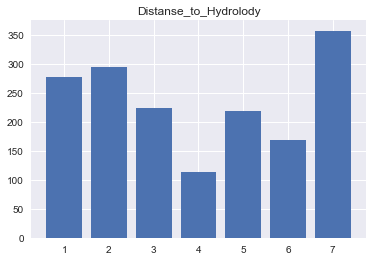

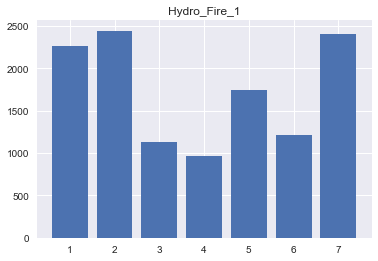

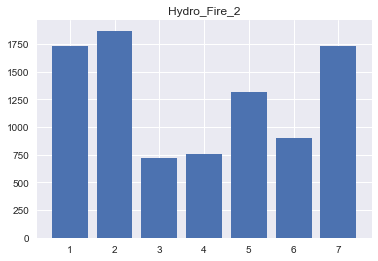

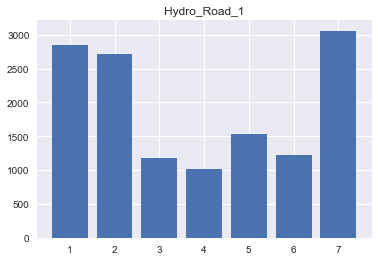

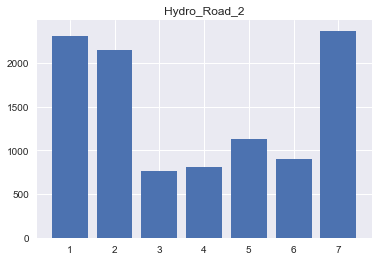

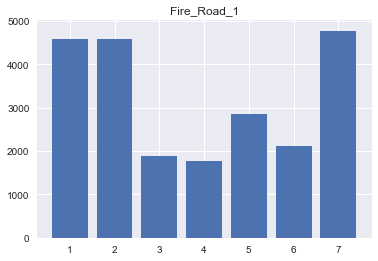

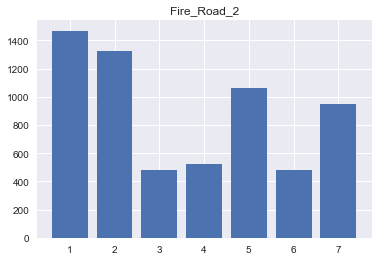

In [34]:

names = ['Distanse_to_Hydrolody', 'Hydro_Fire_1','Hydro_Fire_2', 'Hydro_Road_1', 'Hydro_Road_2', 'Fire_Road_1', 'Fire_Road_2']
for name in names:
    a = []
    for i in range(7):
        a.append(train_data[name][train_target == i + 1].mean())
    plt.bar(range(1, 8), a)
    plt.title(name)
    plt.show()